In [1]:
import string

# For visualization
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import regex as re
import seaborn as sns
import tensorflow_hub as hub
# For cleaning the text
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

pd.set_option('display.max_colwidth', None)

# For building our model

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
ids = test.id
len(train)
print(f'Total length of the dataset: {len(train) + len(test)}')
print(f'Train length: {len(train) + len(test)}')
print(f'Test length: {len(train) + len(test)}')

Total length of the dataset: 10876
Train length: 10876
Test length: 10876


### Detecting null values and records

In [3]:
df_concat = pd.concat([train, test], axis=0).reset_index(drop=True)
nulls = pd.DataFrame(np.c_[df_concat.isnull().sum(), (df_concat.isnull().sum() / len(df_concat)) * 100],
                     columns=['# of nulls', '% of nulls'],
                     index=df_concat.columns)
nulls

,# of nulls,% of nulls
id,0.0,0.000000
keyword,87.0,0.799926
location,3638.0,33.449798
text,0.0,0.000000
target,3263.0,30.001839


### Exploring The Locations and Keywords

In [4]:
for df in [train, test, df_concat]:
    df.keyword.fillna('no_keyword', inplace=True)
    df.location.fillna('no_location', inplace=True)

### Location

In [5]:
# top locations
top_30 = df_concat.groupby(['location']).count().text.sort_values(ascending=False)[:30]
top_30 = top_30[top_30 != 1]
top_30

location
no_location          3638
USA                   141
New York              109
United States          65
London                 58
Canada                 42
Nigeria                40
India                  35
Worldwide              35
Los Angeles, CA        34
UK                     33
Kenya                  32
Washington, DC         31
Mumbai                 28
United Kingdom         26
Australia              25
California             25
Los Angeles            24
San Francisco          23
Chicago, IL            23
New York, NY           22
Florida                21
NYC                    21
California, USA        21
San Francisco, CA      20
Chicago                17
Washington, D.C.       16
Toronto                16
Ireland                15
Everywhere             15
Name: text, dtype: int64

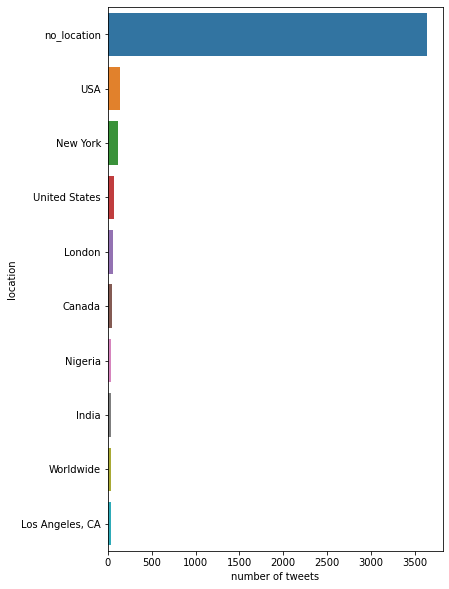

In [6]:
# plot the top 30

plt.figure(figsize=(6, 10))
sns.barplot(x=top_30[:-20], y=top_30[:-20].index)
plt.xlabel('number of tweets');

### Cleaning the data
How we are going to clean:

clean(x, lem = False, stop_w = 'nltk', http = True, punc = True)

In [7]:

sp = spacy.load('en_core_web_sm')

nltk.download('stopwords')
nltk.download('punkt')

# spacy (362 words)
spacy_st = sp.Defaults.stop_words
# nltk(179 words)
nltk_st = stopwords.words('english')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\enrico\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\enrico\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
def clean(tweet, http=True, punc=True, lem=True, stop_w=True):
    if http is True:
        tweet = re.sub("https?:\/\/t.co\/[A-Za-z0-9]*", '', tweet)

    # stop words
    # in here I changed the placement of lower for those of you who want to use
    # Cased BERT later on.
    if stop_w == 'nltk':
        tweet = [word for word in word_tokenize(tweet) if not word.lower() in nltk_st]
        tweet = ' '.join(tweet)

    elif stop_w == 'spacy':
        tweet = [word for word in word_tokenize(tweet) if not word.lower() in spacy_st]
        tweet = ' '.join(tweet)

    # lemmitizing
    if lem == True:
        lemmatized = [word.lemma_ for word in sp(tweet)]
        tweet = ' '.join(lemmatized)

    # punctuation removal
    if punc is True:
        tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # removing extra space
    tweet = re.sub("\s+", ' ', tweet)

    return tweet
df_concat['cleaned_text'] = df_concat.text.apply(lambda x: clean(x, lem = False, stop_w = 'nltk', http = True, punc = True))

In [9]:
df_concat['cleaned_text']

0                                                                               Deeds Reason earthquake May ALLAH Forgive us
1                                                                                      Forest fire near La Ronge Sask Canada
2                                   residents asked shelter place notified officers evacuation shelter place orders expected
3                                                                13000 people receive wildfires evacuation orders California
4                                                                    got sent photo Ruby Alaska smoke wildfires pours school
                                                                ...                                                         
10871                                                                EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
10872    Storm RI worse last hurricane city amp 3others hardest hit yard looks like bombed Around 20000K still without power


In [10]:
cleaned_train = df_concat[:train.shape[0]]
cleaned_test = df_concat[train.shape[0]:]


In [11]:
# Bert Tokenizer for all of them
import tokenization
FullTokenizer = tokenization.FullTokenizer

In [12]:
BERT_MODEL_HUB = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(BERT_MODEL_HUB, trainable=True)
print('Bert layer is ready to use!')


Bert layer is ready to use!


In [13]:
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
#
# tokenizer = FullTokenizer(vocabulary_file, to_lower_case)

In [14]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#
# sentence = 'Terrorist will crush the Tower'
# print('Tokenized version of {} is : \n {} '.format(sentence, tokenizer.tokenize(sentence)))

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
def tokenize_tweets(text_):
    return tokenizer.convert_tokens_to_ids(['[CLS]'] + tokenizer.tokenize(text_) + ['[SEP]'])

df_concat['tokenized_tweets'] = df_concat.cleaned_text.apply(lambda x: tokenize_tweets(x))

cleaned_train.head(2)

,id,keyword,location,text,target,cleaned_text
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,Deeds Reason earthquake May ALLAH Forgive us
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1.0,Forest fire near La Ronge Sask Canada


In [16]:
df_concat

,id,keyword,location,text,target,cleaned_text,tokenized_tweets
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,Deeds Reason earthquake May ALLAH Forgive us,"[101, 15616, 3114, 8372, 2089, 16455, 9641, 2149, 102]"
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1.0,Forest fire near La Ronge Sask Canada,"[101, 3224, 2543, 2379, 2474, 6902, 3351, 21871, 2243, 2710, 102]"
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,residents asked shelter place notified officers evacuation shelter place orders expected,"[101, 3901, 2356, 7713, 2173, 19488, 3738, 13982, 7713, 2173, 4449, 3517, 102]"
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation orders in California",1.0,13000 people receive wildfires evacuation orders California,"[101, 19527, 2692, 2111, 4374, 3748, 26332, 13982, 4449, 2662, 102]"
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,got sent photo Ruby Alaska smoke wildfires pours school,"[101, 2288, 2741, 6302, 10090, 7397, 5610, 3748, 26332, 10364, 2015, 2082, 102]"
...,...,...,...,...,...,...,...
10871,10861,no_keyword,no_location,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn,"[101, 8372, 3808, 3050, 3349, 1057, 2080, 3808, 3435, 24454, 2015, 1060, 2099, 7962, 102]"
10872,10865,no_keyword,no_location,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power,NaN,Storm RI worse last hurricane city amp 3others hardest hit yard looks like bombed Around 20000K still without power,"[101, 4040, 15544, 4788, 2197, 7064, 2103, 23713, 1017, 14573, 2545, 18263, 2718, 4220, 3504, 2066, 18897, 2105, 2456, 2692, 2243, 2145, 2302, 2373, 102]"
10873,10868,no_keyword,no_location,Green Line derailment in Chicago http://t.co/UtbXLcBIuY,NaN,Green Line derailment Chicago,"[101, 2665, 2240, 4315, 12502, 3672, 3190, 102]"
10874,10874,no_keyword,no_location,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,NaN,MEG issues Hazardous Weather Outlook HWO,"[101, 12669, 3314, 17760, 4633, 17680, 1044, 12155, 102]"


In [17]:
# what is the maximum length of our tokenized text?

max_len = len(max(df_concat.tokenized_tweets, key = len))


print('The maximum length of each sequence besed on tokenized tweets is:', max_len)

df_concat['padded_tweets'] = df_concat.tokenized_tweets.apply(lambda x: x + [0] * (max_len - len(x)))
df_concat.head(2)

The maximum length of each sequence besed on tokenized tweets is: 53


,id,keyword,location,text,target,cleaned_text,tokenized_tweets,padded_tweets
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,Deeds Reason earthquake May ALLAH Forgive us,"[101, 15616, 3114, 8372, 2089, 16455, 9641, 2149, 102]","[101, 15616, 3114, 8372, 2089, 16455, 9641, 2149, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1.0,Forest fire near La Ronge Sask Canada,"[101, 3224, 2543, 2379, 2474, 6902, 3351, 21871, 2243, 2710, 102]","[101, 3224, 2543, 2379, 2474, 6902, 3351, 21871, 2243, 2710, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [18]:
# from transformers import AutoModelForSequenceClassification
#
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)


In [19]:
from tweet_classifier import TweetClassifier

classifier = TweetClassifier(tokenizer = tokenizer, bert_layer = bert_layer,
                              max_len = max_len, lr = 0.0001,
                              epochs = 3,  activation = 'sigmoid',
                              batch_size = 32,optimizer = 'SGD',
                              beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [20]:
classifier.train(cleaned_train)

Model is compiled with SGD optimizer
Epoch 1/3
191/191 [==============================] - 541s 3s/step - loss: 0.5220 - accuracy: 0.7489 - val_loss: 0.4211 - val_accuracy: 0.8207

In [21]:
y_pred = np.round(classifier.predict(cleaned_test))

In [22]:
# Submission
sample_sub = pd.read_csv('sample_submission.csv')
ids = sample_sub.id
final_submission = pd.DataFrame( np.c_[ids, y_pred.astype('int')], columns = ['id', 'target'])
final_submission.to_csv('final_submission.csv', index = False)
final_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [23]:

y_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

In [26]:
import tensorflow as tf
new_model = tf.keras.models.load_model('model.h5')

ValueError: Unknown layer: KerasLayer. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.